In [1]:
"40只船舶，2个无人机基站，10个无人机，时间300分钟"
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from numpy import random
import math
import time
import matplotlib.pyplot as plt

In [2]:
# 输入模型参数
num_drones = 10  # 无人机数量
speed_drones = 30  # 无人机的飞行速度是30knots
max_endurance = 120  # 无人机最长续航时间（分钟）(文中的Q)
battery_replacing_time = 5  # 对无人机换电池的时间
Tmax = 300  # 总时长（分钟）
num_stations = 2  # 基站数量
num_vessels = 40  # 船只数量
speed_vessels = 5  # 假设船舶的航速是5konts(文中假设是5~10knots)
inspection_time = 5  # 对船舶的检查时间为5分钟
TmaxSet = [i for i in range(1, Tmax + 1)]

In [3]:
### 节点的生成
station_node = []
base_station = ['s1', 's2']
station_xloc,  station_yloc = {}, {}
for b in base_station:
    for t in range(1, Tmax + 1):
        station_xloc[b] = int(random.uniform(-85, 85))
        station_yloc[b] = 0
        station_node.append((b, t))
station_node = gp.tuplelist(station_node)
weight_station = 0

weight_vessels, vessel_xloc, vessel_yloc = {}, {}, {}
for i in range(1, num_vessels + 1):
    weight_vessels[i] = random.randint(low=5, high=15)
    vessel_xloc[i] = int(random.uniform(-85, 85))
    vessel_yloc[i] = int(random.uniform(0, 20))
vessel_node = gp.tuplelist([(i, t) for i in range(1, num_vessels + 1) for t in range(1, Tmax + 1)])  # 船舶所有的点

node = []
for i in station_node:
    node.append(i)
for i in vessel_node:
    node.append(i)  # 网络中所有的点集合
node = gp.tuplelist(node)

### 弧的生成
SailingTimeSV, SailingTimeVV = {}, {}
# 1station和vessel之间的航行时间
for b in base_station:
    for i in range(1, num_vessels + 1):
        key = (b, i)
        SailingTimeSV[key] = round(math.sqrt(
        math.pow(station_xloc[b] - vessel_xloc[i], 2) + math.pow(station_yloc[b] - vessel_yloc[i], 2)) / speed_drones, 2)
# print(SailingTimeSV)

for i in range(1, num_vessels + 1):
    for j in range(1, num_vessels + 1):
        if i != j:
            SailingTimeVV[i, j] = round(math.sqrt(
                math.pow(vessel_xloc[i] - vessel_xloc[j], 2) + math.pow(vessel_yloc[i] - vessel_yloc[j],
                                                                        2)) / speed_drones, 2)
            Arc, Weight = [], {}
# station到vessel有的弧
for b in base_station:
    for i in range(1, num_vessels + 1):
        for t in range(1, Tmax + 1):
            if t + SailingTimeSV[key] + inspection_time <= Tmax:
                Arc.append((b, t, i, math.ceil(t + SailingTimeSV[key] + inspection_time)))
                Weight[(b, t, i, math.ceil(t + SailingTimeSV[key] + inspection_time))] = (0 + weight_vessels[
                i]) / 2

# vessel到vessel有的弧
for i in range(1, num_vessels + 1):
    for j in range(1, num_vessels + 1):
        if i != j:
            for t in range(1, Tmax + 1):
                if t + SailingTimeVV[i, j] + inspection_time <= Tmax:
                    Arc.append((i, t, j, math.ceil(t + SailingTimeVV[i, j] + inspection_time)))
                    Weight[(i, t, j, math.ceil(t + SailingTimeVV[i, j] + inspection_time))] = \
                        (weight_vessels[i] + weight_vessels[j]) / 2

# vessel到station有的弧
for b in base_station:
    for i in range(1, num_vessels + 1):
        for t in range(1, Tmax + 1):
            if t + SailingTimeSV[key] + battery_replacing_time <= Tmax:
                Arc.append((i, t, b, math.ceil(t + SailingTimeSV[key] + battery_replacing_time)))
                Weight[(i, t, b, math.ceil(t + SailingTimeSV[key] + battery_replacing_time))] = \
                (0 + weight_vessels[i]) / 2

Arc = gp.tuplelist(Arc)

In [4]:
start_time=time.time()
# ----- model -----
m = gp.Model('model')
m.setParam('OutputFlag', 0)  # 表示关闭log输出信息，不观察其输出信息

# decision variable
x = m.addVars(Arc, vtype=GRB.BINARY, name='x')
y = m.addVars(TmaxSet, lb=0, ub=5, vtype=GRB.INTEGER, name='y')
q = m.addVars(node, lb=0, vtype=GRB.CONTINUOUS, name='q')
y[1].Start = num_drones
# objective
m.setObjective(sum(Weight[i] * x[i] for i in Arc), GRB.MAXIMIZE)

# constraints

for (i, t1) in station_node:
    if t1 - 1 >= 1:
        m.addConstr(sum(x[i, t1, j, t2] for (i, t1, j, t2) in Arc.select(i, t1, '*', '*')) - \
                    sum(x[j, t2, i, t1] for (j, t2, i, t1) in Arc.select('*', '*', i, t1)) == y[t1 - 1] - y[t1],
                    name='c1')

for (i, t1) in vessel_node:
    m.addConstr(sum(x[i, t1, j, t2] for (i, t1, j, t2) in Arc.select(i, t1, '*', '*')) - \
                sum(x[j, t2, i, t1] for (j, t2, i, t1) in Arc.select('*', '*', i, t1)) == 0, name='c2')

for (i, t1) in vessel_node:
    for (j, t2) in node:
        if (i, t1, j, t2) in Arc:
            m.addConstr(q[i, t1] - (t2 - t1) * x[i, t1, j, t2] + \
                        (max_endurance + battery_replacing_time) * (1 - x[i, t1, j, t2]) >= q[j, t2], name='c3')

for (i, t1) in station_node:
    for (j, t2) in vessel_node:
        if (i, t1, j, t2) in Arc:
            m.addConstr((max_endurance + battery_replacing_time) - (t2 - t1) * x[i, t1, j, t2] >= q[j, t2], name='c4')

for v in range(1, num_vessels + 1):
    m.addConstr(sum(x[i, t1, v, t2] for (i, t1, v, t2) in Arc.select('*', '*', v, '*')) <= 1, name='c5')

for (i, t1) in station_node:
    m.addConstr(sum(x[i, t1, j, t2] for (i, t1, j, t2) in Arc.select(i, t1, '*', '*')) + \
                sum(x[j, t2, i, t1] for (j, t2, i, t1) in Arc.select('*', '*', i, t1)) <= 1, name='c6')


Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-02


In [5]:
# optimize
m.optimize()
if m.status == GRB.Status.OPTIMAL:
    Obj = m.objVal
    print(f"Optimal Objective Value: {Obj}")
else:
    print("Optimal solution not found.")

# 输出最优性间隙
gap = m.MIPGap
print(f"Optimality Gap: {gap * 100:.2f}%")

# for v in m.getVars():
#     print('%s \t %g' % (v.varName, v.x))
for i in Arc:
    if x[i].x == 1:
        print('x', i, x[i].x)

#for i in TmaxSet:
    #if y[i].x > 0:
        #print('y',i,y[i].x)

#for i in node:
    #if q[i].x > 0:
        #print('q', i, q[i].x)
end_time=time.time()
print('calculate time:' ,end_time-start_time)

Optimal Objective Value: 366.0
Optimality Gap: 0.00%
x ('s1', 202, 1, 209) 1.0
x ('s1', 14, 4, 21) 1.0
x ('s1', 281, 10, 288) 1.0
x ('s1', 167, 16, 174) 1.0
x ('s1', 119, 19, 126) 1.0
x ('s1', 265, 24, 272) 1.0
x ('s2', 202, 3, 209) 1.0
x ('s2', 281, 7, 288) 1.0
x ('s2', 119, 20, 126) 1.0
x ('s2', 265, 28, 272) 1.0
x ('s2', 14, 30, 21) 1.0
x ('s2', 167, 33, 174) 1.0
x (1, 209, 27, 218) 1.0
x (2, 85, 39, 91) 1.0
x (3, 209, 37, 218) 1.0
x (4, 21, 12, 27) 1.0
x (5, 72, 40, 79) 1.0
x (6, 53, 29, 60) 1.0
x (8, 53, 18, 59) 1.0
x (9, 66, 5, 72) 1.0
x (11, 35, 14, 41) 1.0
x (12, 27, 31, 33) 1.0
x (13, 45, 8, 53) 1.0
x (14, 41, 21, 47) 1.0
x (15, 39, 13, 45) 1.0
x (17, 65, 22, 71) 1.0
x (18, 59, 17, 65) 1.0
x (21, 47, 6, 53) 1.0
x (22, 71, 23, 77) 1.0
x (23, 77, 25, 83) 1.0
x (25, 83, 32, 90) 1.0
x (26, 28, 11, 35) 1.0
x (29, 60, 9, 66) 1.0
x (30, 21, 26, 28) 1.0
x (31, 33, 15, 39) 1.0
x (32, 90, 35, 97) 1.0
x (34, 97, 38, 103) 1.0
x (35, 97, 36, 103) 1.0
x (39, 91, 34, 97) 1.0
x (40, 79, 2, 85

In [6]:
selected_paths = [(arc, x[arc].X) for arc in Arc if x[arc].X == 1]

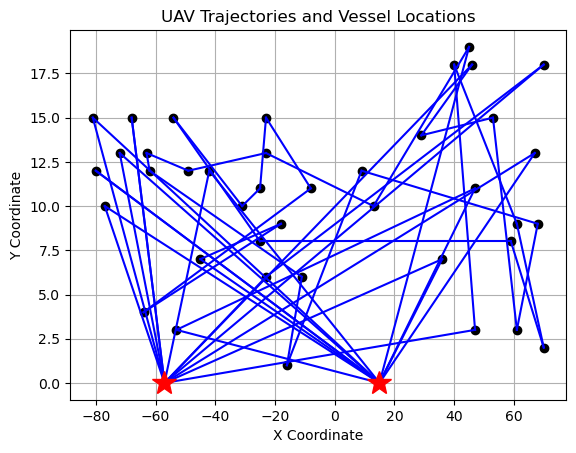

In [7]:
fig, ax = plt.subplots()
for b in base_station:
    vessel_xloc[b] = station_xloc[b]
    vessel_yloc[b] = station_yloc[b]
for v in vessel_xloc.keys():
    plt.plot(vessel_xloc[v], vessel_yloc[v], 'ko')

# 绘制无人机飞行轨迹，使用蓝色线段表示
for arc, value in selected_paths:
    # arc 是一个元组 (起点ID, 起飞时间, 终点ID, 降落时间)
    start_id, _, end_id, _ = arc
    start_x = vessel_xloc[start_id]
    start_y = vessel_yloc[start_id]
    end_x = vessel_xloc[end_id]
    end_y = vessel_yloc[end_id]
    # 绘制从起点到终点的线段
    plt.plot([start_x, end_x], [start_y, end_y], 'b-', label='UAV Path')

for b in base_station:
    plt.plot(station_xloc[b], station_yloc[b], 'r*', markersize=18)
    
plt.title('UAV Trajectories and Vessel Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()